**Post-Processing Amazon Textract with Location-Aware Transformers**

# Part 2: Data Consolidation and Model Training/Deployment

> *This notebook works well with the `Data Science 3.0 (Python 3)` kernel on SageMaker Studio - use the same as for NB1*

In the [first notebook](1.%20Data%20Preparation.ipynb) we worked through preparing a corpus with Amazon Textract and labelling a small sample to highlight entities of interest.

In this part 2, we'll consolidate the labelling job results together with a pre-prepared augmentation set, and actually train and deploy a SageMaker model for word classification.

First, as in the previous notebook, we'll start by importing the required libraries and loading configuration:

In [119]:
%load_ext autoreload
%autoreload 2

# Python Built-Ins:
from datetime import datetime
import json
from logging import getLogger
import os
import random
import time

# External Dependencies:
import boto3  # AWS SDK for Python
import sagemaker
from sagemaker.huggingface import HuggingFace as HuggingFaceEstimator, TrainingCompilerConfig
from tqdm.notebook import tqdm  # Progress bars

# Local Dependencies:
import util

logger = getLogger()

# Manual configuration (check this matches notebook 1):
bucket_name = sagemaker.Session().default_bucket()
bucket_prefix = "textract-transformers/"
print(f"Working in bucket s3://{bucket_name}/{bucket_prefix}")
config = util.project.init("ocr-transformers-invoice")
print(config)

# Field configuration saved from first notebook:
with open("data/field-config.json", "r") as f:
    fields = [
        util.postproc.config.FieldConfiguration.from_dict(cfg)
        for cfg in json.loads(f.read())
    ]
entity_classes = [f.name for f in fields]

# S3 URIs as per first notebook:
raw_s3uri = f"s3://{bucket_name}/{bucket_prefix}data/raw"
imgs_s3uri = f"s3://{bucket_name}/{bucket_prefix}data/imgs-clean"
textract_s3uri = f"s3://{bucket_name}/{bucket_prefix}data/textracted"
thumbs_s3uri = f"s3://{bucket_name}/{bucket_prefix}data/thumbnails"
annotations_base_s3uri = f"s3://{bucket_name}/{bucket_prefix}data/annotations"

# AWS service clients:
s3 = boto3.resource("s3")
smclient = boto3.client("sagemaker")
ssm = boto3.client("ssm")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Working in bucket s3://sagemaker-eu-west-1-031061601856/textract-transformers/
2023-06-30 16:30:29,556 project [INFO] Working in project 'ocr-transformers-invoice'
<util.project.ProjectSession(
  project_id=ocr-transformers-invoice,
  a2i_review_flow_arn_param=/ocr-transformers-invoice/config/HumanReviewFlowArn,
  entity_config_param=/ocr-transformers-invoice/config/EntityConfiguration,
  sagemaker_endpoint_name_param=/ocr-transformers-invoice/config/SageMakerEndpointName,
  thumbnail_endpoint_name_param=/ocr-transformers-invoice/config/ThumbnailEndpointName,
  a2i_execution_role_arn=arn:aws:iam::031061601856:role/OCRPipelineDemo-ProcessingPipelineReviewStepProces-1NGZQPSP8XVIF,
  pipeline_input_bucket_name=ocrpipelinedemo-pipelineinputbucket350ea1ae-gexytk1mnuiv,
  model_callback_topic_arn=arn:aws:sns:eu-west-1:031061601856:OCRPipelineDemo-ProcessingPipelineEnrichmentStepNLPEnrichmentModelSageMaker

## Data Consolidation

To construct a training set, we'll typically need to consolidate the results of multiple SageMaker Ground Truth labelling jobs: Perhaps because the work was split up into more manageable chunks - or maybe because additional review/adjustment jobs were run to improve label quality.

First, we'll download the output folders of all our labelling jobs to the local `data/annotations` folder: (The code here assumes you configured the same `annotations_base_s3uri` output folder for each job in SMGT)

In [120]:
!aws s3 sync --quiet $annotations_base_s3uri ./data/annotations

Inside this folder, you'll find some **pre-annotated augmentation data** provided for you already (in the `augmentation-` subfolders). These datasets are not especially large or externally useful, but will help you train an example model without too much (or even any!) manual annotation effort.

▶️ **Edit** the `include_jobs` line below to control which datasets (pre-provided and your own) will be included:

In [164]:
include_jobs = [
    "label-gas-invocies-factor-30-06-2023",
    "label-gas-invocies-factor-regulation-30-06-2023",
    "label-gas-invocies-factor-regulation-15-samples-30-06-2023",
    # "augmentation-2",
    "label-gas-invocies-vatnova-27-06-2023"
    # TODO: Adjust the below to include the labelling job(s) you created, if you finished labelling:
    # "cfpb-boxes-1",
]


source_manifests = []
for job_name in sorted(filter(
    lambda n: os.path.isdir(f"data/annotations/{n}"),
    os.listdir("data/annotations")
)):
    if job_name not in include_jobs:
        logger.warning(f"Skipping {job_name} (not in include_jobs list)")
        continue
    job_manifest_path = f"data/annotations/{job_name}/manifests/output/output.manifest"
    if not os.path.isfile(job_manifest_path):
        raise RuntimeError(f"Could not find job output manifest {job_manifest_path}")
    source_manifests.append({"job_name": job_name, "manifest_path": job_manifest_path})

print(f"Got {len(source_manifests)} annotated manifests:")
print("\n".join(map(lambda o: o["manifest_path"], source_manifests)))

Got 4 annotated manifests:
data/annotations/label-gas-invocies-factor-30-06-2023/manifests/output/output.manifest
data/annotations/label-gas-invocies-factor-regulation-15-samples-30-06-2023/manifests/output/output.manifest
data/annotations/label-gas-invocies-factor-regulation-30-06-2023/manifests/output/output.manifest
data/annotations/label-gas-invocies-vatnova-27-06-2023/manifests/output/output.manifest


Now that the results are downloaded, we're ready to **consolidate the output manifest files** from each one into a combined manifest file.

Note that to combine multiple output manifests to a single dataset:

- The labels must be stored in the same attribute on every record (records use the labeling job name by default, which will be different between jobs).
- If importing data collected from some other account (like the `augmentation-` sets), we'll need to **map the S3 URIs** to equivalent links on your own bucket.

In [165]:
# Annotations/labels will be standardized to this field on all records:
standard_label_field = "label"

# To import a manifest from somebody else, we of course need to map their bucket names and prefixes
# to ours (and have equivalent files stored in the same locations after the mapping):
BUCKET_MAPPINGS = {"DOC-EXAMPLE-BUCKET": bucket_name}
PREFIX_MAPPINGS = {"EXAMPLE-PREFIX/": bucket_prefix}

print("Writing data/annotations/annotations-all.manifest.jsonl")
with open("data/annotations/annotations-all.manifest.jsonl", "w") as fout:
    for source in tqdm(source_manifests, desc="Consolidating manifests..."):
        with open(source["manifest_path"], "r") as fin:
            for line in filter(lambda l: l, fin):
                obj = json.loads(line)

                # Import refs by applying BUCKET_MAPPINGS and PREFIX_MAPPINGS:
                for k in filter(lambda k: k.endswith("-ref"), obj.keys()):
                    if not obj[k].lower().startswith("s3://"):
                        raise RuntimeError(
                            "Attr %s ends with -ref but does not start with 's3://'\n%s"
                            % (k, obj)
                        )
                    obj_bucket, _, obj_key = obj[k][len("s3://"):].partition("/")
                    obj_bucket = BUCKET_MAPPINGS.get(obj_bucket, obj_bucket)
                    for old_prefix in PREFIX_MAPPINGS:
                        if obj_key.startswith(old_prefix):
                            obj_key = (
                                PREFIX_MAPPINGS[old_prefix]
                                + obj_key[len(old_prefix):]
                            )
                    obj[k] = f"s3://{obj_bucket}/{obj_key}"

                # Find the job output field:
                if source["job_name"] in obj:
                    source_label_attr = source["job_name"]
                elif standard_label_field in obj:
                    source_label_attr = standard_label_field
                else:
                    raise RuntimeError("Couldn't find label field for entry in {}:\n{}".format(
                        source["job_name"],
                        obj,
                    ))
                # Rename to standard:
                obj[standard_label_field] = obj.pop(source_label_attr)
                source_meta_attr = f"{source_label_attr}-metadata"
                if source_meta_attr in obj:
                    obj[f"{standard_label_field}-metadata"] = obj.pop(source_meta_attr)
                # Write to output manifest:
                fout.write(json.dumps(obj) + "\n")

Writing data/annotations/annotations-all.manifest.jsonl


### Split training and test sets

To get some insight on how well our model is generalizing to real-world data, we'll need to reserve some annotated data as a testing/validation set.

Below, we randomly partition the data into training and test sets and then upload the two manifests to S3:

In [166]:
def split_manifest(f_in, f_train, f_test, train_pct=0.9, random_seed=1337):
    """Split `f_in` manifest file into `f_train`, `f_test`"""
    logger.info(f"Reading {f_in}")
    with open(f_in, "r") as fin:
        lines = list(filter(lambda line: line, fin))
    logger.info("Shuffling records")
    random.Random(random_seed).shuffle(lines)
    n_train = round(len(lines) * train_pct)

    with open(f_train, "w") as ftrain:
        logger.info(f"Writing {n_train} records to {f_train}")
        for line in lines[:n_train]:
            ftrain.write(line)
    with open(f_test, "w") as ftest:
        logger.info(f"Writing {len(lines) - n_train} records to {f_test}")
        for line in lines[n_train:]:
            ftest.write(line)


split_manifest(
    "data/annotations/annotations-all.manifest.jsonl",
    "data/annotations/annotations-train.manifest.jsonl",
    "data/annotations/annotations-test.manifest.jsonl",
)

2023-06-30 17:49:04,471 root [INFO] Reading data/annotations/annotations-all.manifest.jsonl
2023-06-30 17:49:04,481 root [INFO] Shuffling records
2023-06-30 17:49:04,494 root [INFO] Writing 94 records to data/annotations/annotations-train.manifest.jsonl
2023-06-30 17:49:04,526 root [INFO] Writing 10 records to data/annotations/annotations-test.manifest.jsonl


In [167]:
train_manifest_s3uri = f"s3://{bucket_name}/{bucket_prefix}data/annotations/annotations-train.manifest.jsonl"
!aws s3 cp data/annotations/annotations-train.manifest.jsonl $train_manifest_s3uri

test_manifest_s3uri = f"s3://{bucket_name}/{bucket_prefix}data/annotations/annotations-test.manifest.jsonl"
!aws s3 cp data/annotations/annotations-test.manifest.jsonl $test_manifest_s3uri

upload: data/annotations/annotations-train.manifest.jsonl to s3://sagemaker-eu-west-1-031061601856/textract-transformers/data/annotations/annotations-train.manifest.jsonl
upload: data/annotations/annotations-test.manifest.jsonl to s3://sagemaker-eu-west-1-031061601856/textract-transformers/data/annotations/annotations-test.manifest.jsonl


### Visualize the data

Before training the model, we'll sense-check the data by plotting a few examples.

The utility function below will overlay the page image with the annotated bounding boxes, the locations of `WORD` blocks detected from the Amazon Textract results, and the resulting classification of individual Textract `WORD`s.

> ⏰ If you Textracted a large number of documents and haven't previously synced them to the notebook, the initial download here may take a few minutes to complete. For our sample set of 120, typically only ~20s is needed.

In [168]:
%%time

!aws s3 sync --quiet $textract_s3uri ./data/textracted

CPU times: user 53.4 ms, sys: 8.58 ms, total: 62 ms
Wall time: 1.55 s


> ⚠️ **Note:** For the interactive visualization widgets in this notebook to work correctly, you'll need the [IPyWidgets extension for JupyterLab](https://ipywidgets.readthedocs.io/en/latest/user_install.html).
>
> On [SageMaker Studio](https://aws.amazon.com/sagemaker/studio/), this should be installed by default. On the classic [SageMaker Notebook Instances](https://docs.aws.amazon.com/sagemaker/latest/dg/nbi.html) though, you'll need to install the `@jupyter-widgets/jupyterlab-manager` extension (from `Settings > Extension Manager`, or using a [lifecycle configuration](https://docs.aws.amazon.com/sagemaker/latest/dg/notebook-lifecycle-config.html) similar to [this sample](https://github.com/aws-samples/amazon-sagemaker-notebook-instance-lifecycle-config-samples/tree/master/scripts/install-lab-extension)) - or just use plain `Jupyter` instead of `JupyterLab`.

In [169]:
with open("data/annotations/annotations-test.manifest.jsonl", "r") as fman:
    test_examples = [json.loads(line) for line in filter(lambda l: l, fman)]

util.viz.draw_from_manifest_items(
    test_examples,
    standard_label_field,
    entity_classes,
    imgs_s3uri[len("s3://"):].partition("/")[2],
    textract_s3key_prefix=textract_s3uri[len("s3://"):].partition("/")[2],
    imgs_local_prefix="data/imgs-clean",
    textract_local_prefix="data/textracted",
)

interactive(children=(IntSlider(value=0, description='Example:', max=9), Output()), _dom_classes=('widget-inte…

<function util.viz.draw_from_manifest_items.<locals>.draw(ix)>

## Prepare custom training and inference containers

SageMaker framework containers like those [for PyTorch](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html) and [Hugging Face](https://sagemaker.readthedocs.io/en/stable/frameworks/huggingface/index.html) support `pip` runtime dependency injection by specifying a `requirements.txt` file in your source bundle - and a specimen requirements file is included in [src/requirements.txt](src/requirements.txt).

This can make experimenting with different library versions faster. **However**, running the installs at each training job / endpoint start-up can make experimenting with script code changes slower. 

Some of the extra computer vision dependencies required for this use case can take a while to install, so in this example we'll build customized containers in advance (as shown in notebook 1 for pre-processing) and leave our requirements.txt empty:

> ℹ️ **Alternatively:** If needed (for example, to experiment with [SageMaker Training Compiler](https://docs.aws.amazon.com/sagemaker/latest/dg/training-compiler.html) which doesn't support customized containers at the time of writing), you could instead:
>
> 1. Uncomment the dependencies listed in [src/requirements.txt](src/requirements.txt)
> 2. Skip the `sm-docker build` steps below, and
> 3. Remove the `image_uri=` arguments later in the notebook

In [170]:
# Configurations:
hf_version = "4.17"
py_version = "py38"
pt_version = "1.10"
train_repo_name = "sm-ocr-training"
train_repo_tag = "hf-4.26-pt-gpu"  # (Base HF version is overridden in Dockerfile)
inf_repo_name = "sm-ocr-inference"
inf_repo_tag = train_repo_tag

account_id = sagemaker.Session().account_id()
region = os.environ["AWS_REGION"]

base_image_params = {
    "framework": "huggingface",
    "region": region,
    "instance_type": "ml.p3.2xlarge",  # (Just used to check whether GPUs/accelerators are used)
    "py_version": py_version,
    "version": hf_version,
    "base_framework_version": f"pytorch{pt_version}",
}

train_base_uri = sagemaker.image_uris.retrieve(**base_image_params, image_scope="training")
inf_base_uri = sagemaker.image_uris.retrieve(**base_image_params, image_scope="inference")

# Combine together into the final URIs:
train_image_uri = f"{account_id}.dkr.ecr.{region}.amazonaws.com/{train_repo_name}:{train_repo_tag}"
print(f"Target training image: {train_image_uri}")
inf_image_uri = f"{account_id}.dkr.ecr.{region}.amazonaws.com/{inf_repo_name}:{inf_repo_tag}"
print(f"Target inference image: {inf_image_uri}")

Target training image: 031061601856.dkr.ecr.eu-west-1.amazonaws.com/sm-ocr-training:hf-4.26-pt-gpu
Target inference image: 031061601856.dkr.ecr.eu-west-1.amazonaws.com/sm-ocr-inference:hf-4.26-pt-gpu


The `--compute-type` parameter below is optional, but can help to speed up image build versus the [default](https://github.com/aws-samples/sagemaker-studio-image-build-cli/blob/87c25051ab033dc81ae1f388515315a70b701157/sagemaker_studio_image_build/cli.py#L100) `BUILD_GENERAL1_SMALL`.

> ⏰ These image builds may take ~12 mins each, but once complete the images will be stored in your Amazon ECR registry and ready to re-use.

In [ ]:
%%time
# (No need to re-run this cell if your train image is already in ECR)

# Build and push the training image:
!cd custom-containers/train-inf && sm-docker build . \
    --compute-type BUILD_GENERAL1_LARGE \
    --repository {train_repo_name}:{train_repo_tag} \
    --role {config.sm_image_build_role} \
    --build-arg BASE_IMAGE={train_base_uri}

Created ECR repository sm-ocr-training
...........[Container] 2023/06/22 13:27:35 Waiting for agent ping

[Container] 2023/06/22 13:27:37 Waiting for DOWNLOAD_SOURCE
[Container] 2023/06/22 13:27:39 Phase is DOWNLOAD_SOURCE
[Container] 2023/06/22 13:27:39 CODEBUILD_SRC_DIR=/codebuild/output/src904028191/src
[Container] 2023/06/22 13:27:39 YAML location is /codebuild/output/src904028191/src/buildspec.yml
[Container] 2023/06/22 13:27:39 Setting HTTP client timeout to higher timeout for S3 source
[Container] 2023/06/22 13:27:39 Processing environment variables
[Container] 2023/06/22 13:27:39 No runtime version selected in buildspec.
[Container] 2023/06/22 13:27:39 Moving to directory /codebuild/output/src904028191/src
[Container] 2023/06/22 13:27:39 Configuring ssm agent with target id: codebuild:8a7fa4f7-6fe5-49ff-b65f-02fe4ef5734a
[Container] 2023/06/22 13:27:39 Successfully updated ssm agent configuration
[Container] 2023/06/22 13:27:39 Registering with agent
[Container] 2023/06/22 13:2

Note that although our training and inference containers use the [same Dockerfile](custom-containers/train-inf/Dockerfile), they're built from different parent images so both are needed in ECR:

In [21]:
%%time
# (No need to re-run this cell if your inference image is already in ECR)

# Build and push the inference image:ç

!cd custom-containers/train-inf && sm-docker build . \
    --compute-type BUILD_GENERAL1_LARGE \
    --repository {inf_repo_name}:{inf_repo_tag} \
    --role {config.sm_image_build_role} \
    --build-arg BASE_IMAGE={inf_base_uri}

...........[Container] 2023/06/22 18:15:28 Waiting for agent ping

[Container] 2023/06/22 18:15:29 Waiting for DOWNLOAD_SOURCE
[Container] 2023/06/22 18:15:31 Phase is DOWNLOAD_SOURCE
[Container] 2023/06/22 18:15:31 CODEBUILD_SRC_DIR=/codebuild/output/src574165044/src
[Container] 2023/06/22 18:15:31 YAML location is /codebuild/output/src574165044/src/buildspec.yml
[Container] 2023/06/22 18:15:31 Setting HTTP client timeout to higher timeout for S3 source
[Container] 2023/06/22 18:15:31 Processing environment variables
[Container] 2023/06/22 18:15:31 No runtime version selected in buildspec.
[Container] 2023/06/22 18:15:31 Moving to directory /codebuild/output/src574165044/src
[Container] 2023/06/22 18:15:31 Configuring ssm agent with target id: codebuild:49920bdc-55df-4c13-b734-b963b73d53f6
[Container] 2023/06/22 18:15:31 Successfully updated ssm agent configuration
[Container] 2023/06/22 18:15:31 Registering with agent
[Container] 2023/06/22 18:15:31 Phases found in YAML: 3
[Container

In [171]:
# Check from notebook whether the images were successfully created:
ecr = boto3.client("ecr")
for repo, tag, uri in (
    (train_repo_name, train_repo_tag, train_image_uri),
    (inf_repo_name, inf_repo_tag, inf_image_uri)
):
    imgs_desc = ecr.describe_images(
        registryId=account_id,
        repositoryName=repo,
        imageIds=[{"imageTag": tag}],
    )
    assert len(imgs_desc["imageDetails"]) > 0, f"Couldn't find ECR image {uri} after build"
    print(f"Found {uri}")

Found 031061601856.dkr.ecr.eu-west-1.amazonaws.com/sm-ocr-training:hf-4.26-pt-gpu
Found 031061601856.dkr.ecr.eu-west-1.amazonaws.com/sm-ocr-inference:hf-4.26-pt-gpu


## (Optional) Self-supervised pre-training

You can run the cell below and **skip the rest of this section**, unless you'd like to dive deeper on this topic:

In [172]:
pretrain = False  # Set this True instead to run pre-training (details below).

## NONE for create new train model or put last training job s3
# Will be overwritten later if pretrain is enabled
pretrained_s3_uri = None 
# pretrained_s3_uri = "s3://sagemaker-eu-west-1-031061601856/textract-transformers/trainjobs/xlm-cfpb-hf-2023-06-30-12-36-23-927/output/model.tar.gz"

In many cases, businesses have a great deal more relevant *unlabelled* data available in addition to the manually labeled dataset. For example, you might have many more historical documents available (with OCR results already, or able to be processed with Amazon Textract) than you're reasonably able to annotate entities on - just as we do in the credit cards example!

Large-scale language models are typically **pre-trained** to unlabelled data in a **self-supervised** pattern: Teaching the model to predict some implicit task in the data like, for example, masking a few words on the page and predicting what words should go in the gaps.

This pre-training doesn't directly teach the model to perform the target task (classifying entities), but forces the core of the model to learn intrinsic patterns in the data. When we then replace the output layers and **fine-tune** towards the target task with human-labelled data, the model is able to learn the target task more effectively.

By default, for speed, the configuration below will use a public pre-trained model from the [Hugging Face Transformers Model Hub](https://huggingface.co/models?search=layoutxlm). This allows us to focus immediately on fine-tuning to our task; but also means accuracy may be degraded if our documents are very different from the original corpus the model was trained on.

**Alternatively, set `pretrain = True` above** to *further* pre-train this same base public model on your own Textracted (but unlabelled) documents first.

> ⚠️ Both these options **use a pre-trained model as a base**: Do check out the licensing and other details for your selected pre-trained `model_name_or_path` on the model hub, as some published models are licensed for non-commercial use only. If you're interested in pre-training your own models from scratch rather than continuation, please let us know on the [existing GitHub issue thread](https://github.com/aws-samples/amazon-textract-transformer-pipeline/issues/19).

Pre-training is most likely to be valuable when:

1. You have a significantly broader range of data available than the core supervised/annotated dataset (e.g. hundreds to thousands of documents or more are available)
2. Your data is usefully *diverse* (millions of nearly-identical proformas may not teach the model very much useful structure, and could pull it away from learning general grammar patterns)
3. ...But within an *unusual or specialized domain* (for example with industry jargon or product names, or a language that's less well-represented in the public model's pre-training - like Indonesian in LayoutXLM).
4. Understanding these language patterns appears to be a limiting factor on model performance (rather than e.g. being just very strongly constrained by lack of annotations or noise in the annotated data).

> ⚠️ If you followed through [Notebook 1](1.%20Data%20Preparation.ipynb) with the default settings to Amazon Textract only a small sample of the documents, you may like to go back, increase `N_DOCS_KEPT`, and Textract some more of the source documents first before trying pre-training.

**In our tests with the Credit Card Agreements sample dataset**, LayoutXLM improved from ~68% to ~74% in downstream NER `eval_focus_else_acc_minus_one` by continuation pre-training on the full ~2,541 document corpus, when averaged over different random seed initializations (standard deviations ~3% over random seeds in each configuration). LayoutLMv1 also appeared to consistently benefit from pre-training, but only very slightly at <1% change in focus accuracy.

> ⚠️ **Note:** Refer to the [Amazon SageMaker Pricing Page](https://aws.amazon.com/sagemaker/pricing/) for up-to-date guidance before running large pre-training jobs.
>
> In our tests at the time of writing:
>
> - Pre-training LayoutXLM on the full ~2,500-document corpus for 25 epochs took around 10 hours on a single-GPU `ml.p3.2xlarge` instance with per-device batch size 2
> - Pre-training LayoutLMv1 on the full ~2,500-document corpus for 25 epochs took around 4 hours on an `ml.p3.8xlarge` instance with per-device batch size 4

> ℹ️ **Notes on *from-scratch* pre-training:**
>
> When particularly large and diverse corpora are available relative to what public models have been trained on (especially when working with low-resource languages for example), you might be interested to try from-scratch pre-training rather than continuing from a public model checkpoint.
>
> To explore this, be aware that:
> - The MLM task implemented in this example is simpler than, and may be different from, the full pre-training objective used by most of these models. For example the [LayoutXLM paper](https://arxiv.org/abs/2104.08836) discusses 3 parallel objectives: Extra work would be required to implement these.
> - Without a good volume and diversity of documents, your results will likely be poor. Check how your dataset(s) compare to the overall size and diversity of those used for pre-training by your target model's original authors.

For self-supervised pre-training, you can utilize the full available corpus of Textract-processed documents: Not just the subset of documents and pages you have annotations for. Reserving some documents for validation is still a good idea though, to understand if and when the model starts to over-fit.

Arguably, including pages from the entity recognition validation dataset in pre-training constitutes [leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)): Because even though we're not including any information about the entity labels the NER model will predict, we're teaching the model information about patterns of content in the hold-out pages.

Therefore, the below code takes a conservative view to avoid possibly over-estimating the added benefits of pre-training: Constructing manifests to route *any document with pages in the entity recognition validation set* to also be in the validation set for pre-training.

In [173]:
selfsup_train_manifest_s3uri = f"s3://{bucket_name}/{bucket_prefix}data/docs-train.manifest.jsonl"
selfsup_val_manifest_s3uri = f"s3://{bucket_name}/{bucket_prefix}data/docs-val.manifest.jsonl"

# To avoid information leakage, take the validation set = the set of all documents with *any* pages
# mentioned in the validation set:
val_textract_s3uris = set()
with open("data/annotations/annotations-test.manifest.jsonl", "r") as f:
    for line in f:
        val_textract_s3uris.add(json.loads(line)["textract-ref"])
with open("data/docs-val.manifest.jsonl", "w") as f:
    for uri in val_textract_s3uris:
        f.write(json.dumps({"textract-ref": uri}) + "\n")
print(f"Added {len(val_textract_s3uris)} docs to pre-training validation set")

# Any Textracted docs not mentioned in validation can go to training:
train_textract_s3uris = set()
with open("data/textracted-all.manifest.jsonl", "r") as fner:
    with open("data/docs-train.manifest.jsonl", "w") as f:
        for line in fner:
            uri = json.loads(line)["textract-ref"]
            if (uri in val_textract_s3uris) or (uri in train_textract_s3uris):
                continue
            else:
                train_textract_s3uris.add(uri)
                f.write(json.dumps({"textract-ref": uri}) + "\n")
print(f"Added {len(train_textract_s3uris)} docs to pre-training set")

Added 10 docs to pre-training validation set
Added 13 docs to pre-training set


In [174]:
!aws s3 cp data/docs-train.manifest.jsonl {selfsup_train_manifest_s3uri}
!aws s3 cp data/docs-val.manifest.jsonl {selfsup_val_manifest_s3uri}

upload: data/docs-train.manifest.jsonl to s3://sagemaker-eu-west-1-031061601856/textract-transformers/data/docs-train.manifest.jsonl
upload: data/docs-val.manifest.jsonl to s3://sagemaker-eu-west-1-031061601856/textract-transformers/data/docs-val.manifest.jsonl


With the Amazon Textract JSONs prepared on S3 and split between training and validation via manifests, we're ready to run the pre-training.

> ▶️ See the following *Fine-tuning on annotated data* section for more parameter details and links on how model training works in SageMaker - which are omitted here since this section is optional.

In general, available hyperparameters are based on the [Hugging Face TrainingArguments parser](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments) with [customizations applied in src/code/config.py](src/code/config.py). See the **"Scaling and optimizing model training"** section of the [Customization Guide](../CUSTOMIZATION_GUIDE.md) for more details on adjusting parallelism and instance type/count - which is particularly relevant for self-supervised pre-training on large datasets.

In [175]:
hyperparameters = {
    # (See src/code/config.py for more info on script parameters)
    "task_name": "mlm",
    "images_prefix": imgs_s3uri[len("s3://"):].partition("/")[2],
    "textract_prefix": textract_s3uri[len("s3://"):].partition("/")[2],

    # LayoutXLM multi-lingual model by default. Other tested base models include:
    # - LayoutLMv2: "microsoft/layoutlmv2-base-uncased"
    # - LayoutLMv1: "microsoft/layoutlm-base-uncased"
    "model_name_or_path": "microsoft/layoutxlm-base",

    "learning_rate": 5e-5,
    "per_device_train_batch_size": 2,
    "per_device_eval_batch_size": 4,

    "num_train_epochs": 30,
    "early_stopping_patience": 15,
    "metric_for_best_model": "eval_loss",
    "greater_is_better": "false",

    # Early stopping implies checkpointing every evaluation (epoch), so limit the total checkpoints
    # kept to avoid filling up disk:
    "save_total_limit": 10,
    "seed": 42,
}

metric_definitions = [
    {"Name": "epoch", "Regex": util.training.get_hf_metric_regex("epoch")},
    {"Name": "learning_rate", "Regex": util.training.get_hf_metric_regex("learning_rate")},
    {"Name": "train:loss", "Regex": util.training.get_hf_metric_regex("loss")},
    {"Name": "validation:loss", "Regex": util.training.get_hf_metric_regex("eval_loss")},
    {
        "Name": "validation:samples_per_sec",
        "Regex": util.training.get_hf_metric_regex("eval_samples_per_second"),
    },
]

pre_estimator = HuggingFaceEstimator(
    role=sagemaker.get_execution_role(),
    # Use "ddp_launcher.py" for native PyTorch DDP, "train.py" for single-GPU or SageMaker DDP:
    entry_point="ddp_launcher.py",
    source_dir="src",
    py_version=py_version,
    pytorch_version=pt_version,
    transformers_version=hf_version,
    image_uri=train_image_uri,  # Use customized training container image

    base_job_name="xlm-cfpb-pretrain",
    output_path=f"s3://{bucket_name}/{bucket_prefix}trainjobs",

    instance_type="ml.g4dn.xlarge",  # Or ml.p3.8xlarge, etc.
    instance_count=1,
    volume_size=100,

    debugger_hook_config=False,  # (Required for LayoutLMv2/XLM, not for v1)
    # To enable SageMaker DDP (on supported instance types):
    # distribution={"smdistributed": {"dataparallel": {"enabled": True}}},

    hyperparameters=hyperparameters,
    metric_definitions=metric_definitions,
    environment={
        # Required for our custom dataset loading code (which depends on tokenizer):
        "TOKENIZERS_PARALLELISM": "false",
        # May be useful for debugging some DDP issues:
        # "TORCH_DISTRIBUTED_DEBUG": "INFO",
    },
)

In [176]:
if pretrain:
    pre_estimator.fit(
        inputs={
            "images": thumbs_s3uri,  # (Can omit this channel with LayoutLMv1 for performance)
            "train": selfsup_train_manifest_s3uri,
            "textract": textract_s3uri + "/",
            "validation": selfsup_val_manifest_s3uri,
        },
        #wait=False,
    )

Once the pre-training is complete, fetch the output model S3 URI to use as input for the fine-tuning stage:

In [177]:
if pretrain:
    # Un-comment this first line to load an previous pre-training job instead:
    # pre_estimator = HuggingFaceEstimator.attach("xlm-cfpb-pretrain-2023-06-27-13-48-02-149")

    pretraining_job_desc = pre_estimator.latest_training_job.describe()
    pretrained_s3_uri = pretraining_job_desc["ModelArtifacts"]["S3ModelArtifacts"]

print(f"Custom pre-trained model: {pretrained_s3_uri}")

Custom pre-trained model: None


## Fine-tuning on annotated data

In this section we'll run a [SageMaker Training Job](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-training.html) to fine-tune the model on our annotated dataset.

In this process:

- SageMaker will run the job on a dedicated, managed instance of type we choose (we'll use `ml.p*` or `ml.g*` GPU-accelerated types), allowing us to keep this notebook's resources modest and only pay for the seconds of GPU time the training job needs.
- The data as specified in the manifest files will be downloaded from Amazon S3.
- The bundle of scripts we provide (in `src/`) will be transparently uploaded to S3 and then run inside the specified SageMaker-provided [framework container](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers-prebuilt.html). There's no need for us to build our own container image or implement a serving stack for inference (although fully-custom containers are [also supported](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers.html)).
- Job hyperparameters will be passed through to our `src/` scripts as CLI arguments.
- SageMaker will analyze the logs from the job (i.e. `print()` or `logger` calls from our script) with the regular expressions specified in `metric_definitions`, to scrape structured timeseries metrics like loss and accuracy.
- When the job finishes, the contents of the `model` folder in the container will be automatically tarballed and uploaded to a `model.tar.gz` in Amazon S3.

Rather than orchestrating this process through the low-level [SageMaker API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateTrainingJob.html) (e.g. via [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_training_job)), we'll use the open-source [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/) (`sagemaker`) for convenience. You can also refer to [Hugging Face's own docs for training on SageMaker](https://huggingface.co/transformers/sagemaker.html) for more information and examples.

First, we'll configure some parameters you may **sometimes wish to re-use across training jobs**. Continuation jobs may want to use the same checkpoint location in S3, while from-scratch training should start fresh

▶️ You can choose when to re-run this cell between experiments:

In [178]:
checkpoint_collection_name = "checkpoints-" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
print(f"Saving checkpoints to collection {checkpoint_collection_name}")

checkpoint_s3_uri = f"s3://{bucket_name}/{bucket_prefix}checkpoints/{checkpoint_collection_name}"

Saving checkpoints to collection checkpoints-2023-06-30-17-50-53


Next, we'll define the core configuration for our training job:

▶️ This should usually be re-run for every new training job

In [137]:
hyperparameters = {
    # (See src/code/config.py for more info on script parameters)
    "annotation_attr": standard_label_field,
    "images_prefix": imgs_s3uri[len("s3://"):].partition("/")[2],
    "textract_prefix": textract_s3uri[len("s3://"):].partition("/")[2],
    "num_labels": len(fields) + 1,  # +1 for "other"

    "per_device_train_batch_size": 2,
    "per_device_eval_batch_size": 4,

    "num_train_epochs": 170,  # Set high for automatic HP tuning later
    "early_stopping_patience": 20,  # Usually stops after <25 epochs on this sample data+config
    "metric_for_best_model": "eval_focus_else_acc_minus_one",
    "greater_is_better": "true",

    # Early stopping implies checkpointing every evaluation (epoch), so limit the total checkpoints
    # kept to avoid filling up disk:
    "save_total_limit": 10,
}
if not pretrained_s3_uri:
    # LayoutXLM multi-lingual model by default. Other tested base models include:
    # - LayoutLMv2: "microsoft/layoutlmv2-base-uncased"
    # - LayoutLMv1: "microsoft/layoutlm-base-uncased"
    # See HF model hub for licensing & details of pre-trained models: https://huggingface.co/models
    hyperparameters["model_name_or_path"] = "microsoft/layoutxlm-base"


metric_definitions = [
    {"Name": "epoch", "Regex": util.training.get_hf_metric_regex("epoch")},
    {"Name": "learning_rate", "Regex": util.training.get_hf_metric_regex("learning_rate")},
    {"Name": "train:loss", "Regex": util.training.get_hf_metric_regex("loss")},
    {
        "Name": "validation:n_examples",
        "Regex": util.training.get_hf_metric_regex("eval_n_examples"),
    },
    {"Name": "validation:loss_avg", "Regex": util.training.get_hf_metric_regex("eval_loss")},
    {"Name": "validation:acc", "Regex": util.training.get_hf_metric_regex("eval_acc")},
    {
        "Name": "validation:n_focus_examples",
        "Regex": util.training.get_hf_metric_regex("eval_n_focus_examples"),
    },
    {
        "Name": "validation:focus_acc",
        "Regex": util.training.get_hf_metric_regex("eval_focus_acc"),
    },
    {
        "Name": "validation:target",
        "Regex": util.training.get_hf_metric_regex("eval_focus_else_acc_minus_one"),
    },
]

estimator = HuggingFaceEstimator(
    role=sagemaker.get_execution_role(),
    entry_point="train.py",
    source_dir="src",
    py_version=py_version,
    pytorch_version=pt_version,
    transformers_version=hf_version,
    image_uri=train_image_uri,  # Use customized training container image

    base_job_name="xlm-cfpb-hf",
    output_path=f"s3://{bucket_name}/{bucket_prefix}trainjobs",
    # checkpoint_s3_uri=checkpoint_s3_uri,  # Un-comment to turn on checkpoint upload to S3

    instance_type="ml.g4dn.xlarge",  # Could also consider ml.p3.2xlarge or ml.g4dn.xlarge
    instance_count=1,
    volume_size=80,

    debugger_hook_config=False,  # (Required for LayoutLMv2/XLM, not for v1)

    hyperparameters=hyperparameters,
    metric_definitions=metric_definitions,
    environment={
        # Required for our custom dataset loading code (which depends on tokenizer):
        "TOKENIZERS_PARALLELISM": "false",
    },
)

Finally, the below cell will actually kick off the training job and stream logs from the running container.

> ℹ️ You'll also be able to check the status of the job in the [Training jobs page of the SageMaker Console](https://console.aws.amazon.com/sagemaker/home?#/jobs).

In [138]:
inputs = {
    "images": thumbs_s3uri,    # (Can omit this channel with LayoutLMv1 for performance)
    "train": train_manifest_s3uri,
    "textract": textract_s3uri + "/",
    "validation": test_manifest_s3uri,
}
if pretrained_s3_uri:
    print(f"Using custom pre-trained model {pretrained_s3_uri}")
    inputs["model_name_or_path"] = pretrained_s3_uri

estimator.fit(inputs)

Using custom pre-trained model s3://sagemaker-eu-west-1-031061601856/textract-transformers/trainjobs/xlm-cfpb-hf-2023-06-30-12-36-23-927/output/model.tar.gz
Using provided s3_resource
2023-06-30 16:33:06 Starting - Starting the training job...
2023-06-30 16:33:21 Starting - Preparing the instances for training......
2023-06-30 16:34:19 Downloading - Downloading input data......
2023-06-30 16:35:34 Training - Downloading the training image.......................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-06-30 16:39:16,629 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-06-30 16:39:16,653 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-06-30 16:39:16,656 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-06-30 16:39:16,836 sagemaker-training-toolkit INFO     Installing dependencies from requi

## (Optional) Hyperparameter tuning

Particularly when applying novel techniques or working in new domains, we'll often need to find good values for a range of different *hyperparameters* of our proposed algorithms.

Rather than spending time manually adjusting these parameters, we can use [SageMaker Automatic Model Tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html) which uses an intelligent [Bayesian optimization approach](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html) to efficiently and automatically search for high-performing combinations over several training jobs.

You can optionally run the cell below to kick off an HPO job for the model:

In [ ]:
# tuner = sagemaker.tuner.HyperparameterTuner(
#     estimator,
#     "validation:target",
#     base_tuning_job_name="xlm-cfpb-hpo",
#     hyperparameter_ranges={
#         "learning_rate": sagemaker.parameter.ContinuousParameter(
#             1e-8,
#             1e-3,
#             scaling_type="Logarithmic",
#         ),
#         "per_device_train_batch_size": sagemaker.parameter.CategoricalParameter([2, 4, 6, 8]),
#         "label_smoothing_factor": sagemaker.parameter.CategoricalParameter([0.0, 1e-12, 1e-9, 1e-6]),
#     },
#     metric_definitions=metric_definitions,
#     strategy="Bayesian",
#     objective_type="Maximize",
#     max_jobs=21,
#     max_parallel_jobs=2,
#     # early_stopping_type="Auto",  # Off by default - could consider turning it on
# #     warm_start_config=sagemaker.tuner.WarmStartConfig(
# #         warm_start_type=sagemaker.tuner.WarmStartTypes.IDENTICAL_DATA_AND_ALGORITHM,
# #         parents={ "xlm-cfpb-hpo-210723-1625" },
# #     ),
# )

# tuner.fit(
#     inputs={
#         "images": thumbs_s3uri,    # (Can omit this channel with LayoutLMv1 for performance)
#         "train": train_manifest_s3uri,
#         "textract": textract_s3uri + "/",
#         "validation": test_manifest_s3uri,
#     },
#     wait=False,
# )

This job will run asynchronously so won't block the notebook, but you can check on the status from the [Hyperparameter tuning jobs list](https://console.aws.amazon.com/sagemaker/home?#/hyper-tuning-jobs) of the SageMaker Console.

## Deploy the model

Once our model is trained (or maybe even automatically hyperparameter-tuned over several training jobs), we can prepare to use it for inference.

Note that if, for some reason, you need to recover the state of a previous training or tuning job after a notebook restart or similar, you can `attach()` to training or tuning jobs by name - as shown below:

In [139]:
# If needed, you can attach to a previous training job by name like this:
estimator = HuggingFaceEstimator.attach("xlm-cfpb-hf-2023-06-30-16-33-06-127")
# tuner = sagemaker.tuner.HyperparameterTuner.attach("llmv2-cfpb-hpo-210603-0542")


2023-06-30 17:20:17 Starting - Preparing the instances for training
2023-06-30 17:20:17 Downloading - Downloading input data
2023-06-30 17:20:17 Training - Training image download completed. Training in progress.
2023-06-30 17:20:17 Uploading - Uploading generated training model
2023-06-30 17:20:17 Completed - Training job completed


SageMaker supports a [range of different deployment types](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html) for inference: You may already be familiar with the [real-time](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html) and [batch transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) options from the [main SageMaker Example Notebook repository](https://github.com/aws/amazon-sagemaker-examples).

For document processing use-cases like this one though, [SageMaker asynchronous inference](https://docs.aws.amazon.com/sagemaker/latest/dg/async-inference.html) may be a better fit:

1. Unlike real-time endpoints (at the time of writing), asynchronous endpoints can [auto-scale down to zero instances](https://docs.aws.amazon.com/sagemaker/latest/dg/async-inference-autoscale.html). This can offer substantial cost savings if your business process is low-volume and often idle: With the trade-off that overall process latency may increase, especially for cold-start requests.
1. Asynchronous inference can support longer timeouts and larger request/response payload sizes than real-time: Which can be useful in cases where an individual document may be long and take a significant time to process with a model.
    - While you can work around the payload size restriction in real-time endpoints by accepting and returning JSON pointers to S3 objects, instead of passing large payloads inline, the inference time-out could still become an issue for particularly heavy requests

To deploy our model to an asynchronous endpoint ready to integrate to the OCR pipeline stack:

- As detailed in the [SDK docs](https://sagemaker.readthedocs.io/en/stable/overview.html#sagemaker-asynchronous-inference), the optional `async_inference_config` parameter tells SageMaker that the endpoint will be asynchronous rather than real-time.
- For permissions integration, our async endpoint will need to store its outputs in the proper S3 location the pipeline is expecting (`output_path`). We can look that up from here in the notebook via the same SSM-based `config` we've seen before.
- To resume the pipeline when the model processes a document, our endpoint will need to notify the pipeline's SNS topic. Again, this is given on `config`.
- While the *SageMaker* limits on request/response size and response timeouts are higher for asynchronous endpoints than real-time, we need to also make sure the serving stack *within the container* is configured to support very large payloads. Setting the `MMS_*` environment variables below prevents errors related to this. For more information see the [AWSLabs Multi-Model Server configuration doc](https://github.com/awslabs/multi-model-server/blob/master/docs/configuration.md) and corresponding page [for TorchServe](https://github.com/pytorch/serve/blob/master/docs/configuration.md#other-properties).

In [140]:
# Configure async endpoint settings for the pipeline stack:
async_inference_config = sagemaker.async_inference.AsyncInferenceConfig(
    output_path=f"s3://{config.model_results_bucket}",
    max_concurrent_invocations_per_instance=4,  # (Can tune this for performance)
    notification_config={
        "SuccessTopic": config.model_callback_topic_arn,
        "ErrorTopic": config.model_callback_topic_arn,
    },
)

# Extra environment variables to enable large payloads in async
async_extra_env_vars = {
    "MMS_DEFAULT_RESPONSE_TIMEOUT": str(60*3),  # 3min instead of default (maybe 60sec?)
    "MMS_MAX_REQUEST_SIZE": str(100*1024*1024),  # 100MiB instead of default ~6.2MiB
    "MMS_MAX_RESPONSE_SIZE": str(100*1024*1024),  # 100MiB instead of default ~6.2MiB
}

### Easy one-click deployment

For straightforward deployment, you can just call `estimator.deploy()` (or equivalently, `tuner.deploy()`) - specifying the extra `async_inference_config` and environment variables for our target async deployment:

> ⚠️ **Warning:** If you change inference code (e.g. [src/code/inference.py](src/code/inference.py)) and re-deploy by this one-click method, your change will likely not be picked up. See the deep-dive section below instead, for making updates.

In [141]:
training_job_name = estimator.latest_training_job.describe()["TrainingJobName"]
# Or:
# training_job_name = tuner.best_training_job()
# training_job_name = "ocr-training-job-invocies-endpoint"
predictor = estimator.deploy(
    # Avoid us accidentally deploying the same model twice by setting name per training job:
    endpoint_name=training_job_name,
    initial_instance_count=1,
    instance_type="ml.t2.large",
    image_uri=inf_image_uri,
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
    env={
        "PYTHONUNBUFFERED": "1",  # TODO: Disable once debugging is done
        **async_extra_env_vars,
    },
    async_inference_config=async_inference_config,
)

-------------!

### (Optional) Digging deeper into the model

Alternatively, you may instead want to explore the artifacts saved by the training job, or edit the `code` script bundle before deploying the endpoint - especially for debugging any problems with inference. Let's see how:

In [ ]:
# Look up job name and artifact location from previous training job as before:
training_job_desc = estimator.latest_training_job.describe()
model_s3uri = training_job_desc["ModelArtifacts"]["S3ModelArtifacts"]
model_name = training_job_desc["TrainingJobName"]

In [ ]:
# *Optionally* download and extract the contents of the model.tar.gz locally:
# (Deleting old data/model folder if it exists)
!rm -rf ./data/model
!aws s3 cp $model_s3uri ./data/model/model.tar.gz
!cd data/model && tar -xzvf model.tar.gz

In [ ]:
from sagemaker.huggingface import HuggingFaceModel

try:
    # Make sure we don't accidentally re-use same model:
    smclient.delete_model(ModelName=model_name)
    print(f"Deleted existing model {model_name}")
except smclient.exceptions.ClientError as e:
    if not (
        e.response["Error"]["Code"] in (404, "404")
        or e.response["Error"].get("Message", "").startswith("Could not find model")
    ):
        raise e

model = HuggingFaceModel(
    name=model_name,
    model_data=model_s3uri,
    role=sagemaker.get_execution_role(),
    source_dir="src/",
    entry_point="inference.py",
    py_version=py_version,
    pytorch_version=pt_version,
    transformers_version=hf_version,
    image_uri=inf_image_uri,
    env={
        "PYTHONUNBUFFERED": "1",  # TODO: Disable once debugging is done
        **async_extra_env_vars,
    },
)

In [ ]:
try:
    # Delete previous endpoint, if already in use:
    predictor.delete_endpoint(delete_endpoint_config=True)
    print("Deleting previous endpoint...")
    time.sleep(8)
except (NameError, smclient.exceptions.ResourceNotFound):
    pass  # No existing endpoint to delete
except smclient.exceptions.ClientError as e:
    if "Could not find" not in e.response["Error"].get("Message", ""):
        raise e

print("Deploying model...")
predictor = model.deploy(
    endpoint_name=training_job_desc["TrainingJobName"],
    initial_instance_count=1,
    instance_type="ml.t2.medium",
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
    async_inference_config=async_inference_config,
)
print("\nDone!")

## Extract clean input images on-demand

> ▶️ If you're using LayoutLMv1, you can skip this section

Some models (like LayoutLMv2/XLM, but **not** LayoutLMv1) consume **page images** in addition to text and layout data.

The same code we used in notebook 1 to extract clean page images from raw source documents, can be deployed as an (asynchronous) *inference endpoint* for *on-demand* page thumbnail image generation whenever a new document comes in. If you deployed the pipeline CDK stack with the default options, this endpoint should be **already deployed for you** and can be located as shown below:

In [142]:
if config.thumbnails_callback_topic_arn == "undefined":
    logger.warning(
        "This pipeline CDK stack was deployed with thumbnailing disabled (by setting parameter "
        "use_thumbnails=False). Even if you manually deploy a thumbnailing endpoint from the "
        "notebook, it will not be used in online processing."
    )

preproc_endpoint_name = ssm.get_parameter(
    Name=config.thumbnail_endpoint_name_param,
)["Parameter"]["Value"]
print(f"Pre-created thumbnailer endpoint name:\n  {preproc_endpoint_name}")

if preproc_endpoint_name == "undefined":
    raise ValueError(
        "The thumbnailing endpoint was not automatically created by this pipeline's CDK stack "
        "deployment. See the 'Optional Extras.ipynb' notebook for instructions to manually deploy "
        "the thumbnailer before continuing."
    )

Pre-created thumbnailer endpoint name:
  ProcessingPipelineThumbnailStepThumbnailerDeployme-JysZyww32Wp0


> ℹ️ If the thumbnailer endpoint is **missing or mis-configured** in your environment:
> 
> - **Check** whether your pipeline is deployed with online thumbnailing support enabled
>     - This is not mandatory for experimenting with alternative models in notebook, but if you later connect a model that consumes thumbnails to a pipeline that doesn't generate them, model accuracy will be degraded.
>     - To confirm, find your *pipeline* state machine in [AWS Step Functions](https://console.aws.amazon.com/states/home?#/statemachines) (the one containing NLP and post-processing steps), and check it runs a Thumbnail Generation step in parallel to OCR.
>     - To update, configure the `USE_THUMBNAILS` environment variable referenced by [/cdk_app.py](../cdk_app.py) and re-deploy your CDK app. Check whether your version of the CDK code supports auto-deploying the endpoint.
> - **If necessary, manually set up** a thumbnailing endpoint:
>     - See the thumbnailing deployment instructions in [Optional Extras.ipynb](Optional%20Extras.ipynb)
>     - You can re-run the above cell if you connected the custom thumbnailer to your pipeline, or just set `preproc_endpoint_name` here

In [143]:
try:
    desc = smclient.describe_endpoint(EndpointName=preproc_endpoint_name)
except smclient.exceptions.ClientError as e:
    if e.response.get("Error", {}).get("Message", "").startswith("Could not find"):
        desc = None  # Endpoint does not exist
    else:
        raise e  # Some other unknown issue

if desc is None:
    raise ValueError(
        "The configured thumbnailing endpoint does not exist in SageMaker. See the 'Optional "
        "Extras.ipynb' notebook for instructions to manually deploy the thumbnailer before "
        "continuing. Missing endpoint: %s" % preproc_endpoint_name
    )

preproc_predictor = sagemaker.predictor_async.AsyncPredictor(
    sagemaker.Predictor(
        preproc_endpoint_name,
        serializer=util.deployment.FileSerializer.from_filename("any.pdf"),
        deserializer=util.deployment.CompressedNumpyDeserializer(),
    ),
    name=preproc_endpoint_name,
)

This endpoint accepts images or documents and outputs resized page thumbnail images.

For multi-page documents the main output format is `application/x-npz`, which produces a [compressed numpy archive](https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html#numpy.savez_compressed) in which `images` is an **array of images** each represented by **PNG bytes**. These formats require customizing the client (predictor) *serializer* and *deserializer* from the default for PyTorch. Since `Predictor` de/serializers set the `Content-Type` and `Accept` headers, we'll also need to re-configure the serializer whenever switching between input document types (for example PDF vs PNG).

To support potentially large documents, the preprocessor is deployed to an **asynchronous** endpoint which enables larger request and response payload sizes.

So how would it look to test the endpoint from Python? Let's see an example:

Calling endpoint...
Got response of type <class 'numpy.lib.npyio.NpzFile'>


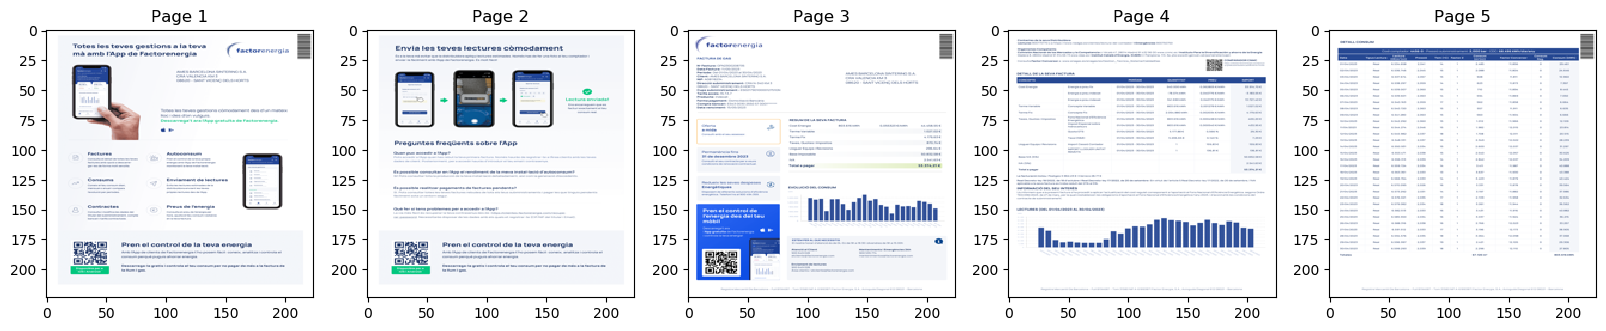

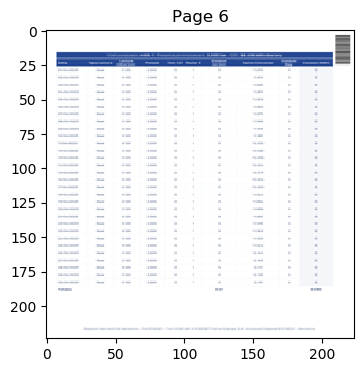

CPU times: user 1.14 s, sys: 15.3 ms, total: 1.16 s
Wall time: 31.8 s


In [154]:
%%time

# Choose an input (document or image):
# input_file = "data/VATNOVA/MAYO_VATNOVA_ES0217901000002001CA.pdf"
# input_file = "data/FACTOR/ABRIL_FACTOR_ES0217901000013047VD.pdf" 
input_file = "data/FACTOR/ABRIL_FACTOR_ES0217901000012751GN.pdf"
#input_file = "data/imgs-clean/121 Financial Credit Union/Visa Credit Card Agreement-0001-1.png"

# Ensure de/serializers are correctly set up:
preproc_predictor.serializer = util.deployment.FileSerializer.from_filename(input_file)
preproc_predictor.deserializer = util.deployment.CompressedNumpyDeserializer()
# Duplication because of https://github.com/aws/sagemaker-python-sdk/issues/3100
preproc_predictor.predictor.serializer = preproc_predictor.serializer
preproc_predictor.predictor.deserializer = preproc_predictor.deserializer

# Run prediction:
print("Calling endpoint...")
resp = preproc_predictor.predict(input_file)
print(f"Got response of type {type(resp)}")

# Render result:
util.viz.draw_thumbnails_response(resp)

## Using the Model

Once the deployment is complete (and, if our model takes image inputs, the page thumbnail generator endpoint is ready), we're ready to try it out with some requests!

In [155]:
# As with estimators, you can also attach the notebook to previously deployed endpoints like this:

preproc_endpoint_name="ProcessingPipelineThumbnailStepThumbnailerDeployme-JysZyww32Wp0"
preproc_predictor = sagemaker.predictor_async.AsyncPredictor(
    sagemaker.Predictor(
        preproc_endpoint_name,
        serializer=util.deployment.FileSerializer.from_filename("any.pdf"),
        deserializer=util.deployment.CompressedNumpyDeserializer(),
    ),
    name=preproc_endpoint_name,
)

# endpoint_name="xlm-cfpb-hf-2023-06-30-08-36-39-341"
endpoint_name = training_job_name
predictor = sagemaker.predictor_async.AsyncPredictor(
    sagemaker.Predictor(
        endpoint_name,
        serializer=sagemaker.serializers.JSONSerializer(),
        deserializer=sagemaker.deserializers.JSONDeserializer(),
    ),
    name=endpoint_name,
)

### Making requests and rendering results

At a high level, the layout+language model accepts Textract-like JSON (e.g. as returned by [AnalyzeDocument](https://docs.aws.amazon.com/textract/latest/dg/API_AnalyzeDocument.html#API_AnalyzeDocument_ResponseSyntax) or [DetectDocumentText](https://docs.aws.amazon.com/textract/latest/dg/API_DetectDocumentText.html#API_DetectDocumentText_ResponseSyntax) APIs) and classifies each `WORD` [block](https://docs.aws.amazon.com/textract/latest/dg/API_Block.html) according to the entity classes we defined earlier: Returning the same JSON with additional fields added to indicate the predictions.

In addition (per the logic in [src/code/inference.py](src/code/inference.py)):

- To incorporate image features (for models that support them), requests can also include an `S3Thumbnails: { Bucket, Key }` object pointing to a thumbnailer endpoint response on S3.
- Instead of passing the (typically large and already-S3-resident) Amazon Textract JSON inline, an `S3Input: { Bucket, Key }` reference can be passed instead (and this is actually how the standard pipeline integration works).
- Output could also be redirected by passing an `S3Output: { Bucket, Key }` field in the request, but this is ignored and not needed on async endpoint deployments.
- `TargetPageNum` and `TargetPageOnly` fields can be specified to limit processing to a single page of the input document.

We can use utility functions to render these predictions as we did the manual annotations previously:

> ⏰ **Inference may take time in some cases:**
>
> - Although enabling thumbnails can increase demo inference time below by several seconds, the end-to-end pipeline generates these images in parallel with running Amazon Textract - so there's usually no significant impact in practice.
> - If you enabled **auto-scale-to-zero** on your your thumbnailer and/or model endpoint, you may see a cold-start of several minutes.

> ⚠️ **Check:** Because of the way the SageMaker Python SDK's [AsyncPredictor](https://sagemaker.readthedocs.io/en/stable/api/inference/predictor_async.html) emulates a synchronous `predict()` interface for async endpoints, you may find the notebook waits indefinitely instead of raising an error when something goes wrong. If an inference takes more than ~30s to complete, check the endpoint logs from your [SageMaker Console Endpoints page](https://console.aws.amazon.com/sagemaker/home?#/endpoints) to see if your request resulted in an error.

In [156]:
import ipywidgets as widgets
import trp

# Enabling thumbnails can significantly increase inference time here, but can improve results for
# models that consume image features (like LayoutLMv2, XLM):
include_thumbnails = False

def predict_from_manifest_item(
    item,
    predictor,
    imgs_s3key_prefix=imgs_s3uri[len("s3://"):].partition("/")[2],
    raw_s3uri_prefix=raw_s3uri,
    textract_s3key_prefix=textract_s3uri[len("s3://"):].partition("/")[2],
    imgs_local_prefix="data/imgs-clean",
    textract_local_prefix="data/textracted",
    draw=True,
):
    paths = util.viz.local_paths_from_manifest_item(
        item,
        imgs_s3key_prefix,
        textract_s3key_prefix=textract_s3key_prefix,
        imgs_local_prefix=imgs_local_prefix,
        textract_local_prefix=textract_local_prefix,
    )

    if include_thumbnails:
        doc_textract_s3key = item["textract-ref"][len("s3://"):].partition("/")[2]
        doc_raw_s3uri = raw_s3uri_prefix + doc_textract_s3key[len(textract_s3key_prefix):].rpartition("/")[0]
        print(f"Fetching thumbnails for {doc_raw_s3uri}")
        thumbs_async = preproc_predictor.predict_async(input_path=doc_raw_s3uri)
        thumbs_bucket, _, thumbs_key = thumbs_async.output_path[len("s3://"):].partition("/")
        # Wait for the request to complete:
        thumbs_async.get_result(sagemaker.async_inference.WaiterConfig())
        req_extras = {"S3Thumbnails": {"Bucket": thumbs_bucket, "Key": thumbs_key}}
        print("Got thumbnails result")
    else:
        req_extras = {}

    result_json = predictor.predict({
        "S3Input": {"S3Uri": item["textract-ref"]},
        "TargetPageNum": item["page-num"],
        "TargetPageOnly": True,
        **req_extras,
    })

    if "Warnings" in result_json:
        for warning in result_json["Warnings"]:
            logger.warning(warning)
    result_trp = trp.Document(result_json)

    if draw:
        util.viz.draw_smgt_annotated_page(
            paths["image"],
            entity_classes,
            annotations=[],
            textract_result=result_trp,
            # Note that page_num should be item["page-num"] if we requested the full set of pages
            # from the model above:
            page_num=1,
        )
    return result_trp


widgets.interact(
    lambda ix: predict_from_manifest_item(test_examples[ix], predictor),
    ix=widgets.IntSlider(
        min=0,
        max=len(test_examples) - 1,
        step=1,
        value=0,
        description="Example:",
    )
)

interactive(children=(IntSlider(value=0, description='Example:', max=9), Output()), _dom_classes=('widget-inte…

<function __main__.<lambda>(ix)>

### From token classification to entity detection

You may have noticed a slight mismatch: We're talking about extracting 'fields' or 'entities' from the document, but our model just classifies individual words. Going from words to entities assumes we're able to understand which words go "together" and what order they should be read in.

Fortunately, Textract helps us out with this too as the word blocks are already collected into `LINE`s.

For many straightforward applications, we can simply loop through the lines on a page and define an "entity detection" as a contiguous group of the same class - as below:

In [147]:
res = predict_from_manifest_item(
    test_examples[0],
    predictor,
    draw=False,
)

2023-06-30 17:35:37,699 root [WARNING] SageMaker model's preprocessor (<class 'transformers.models.layoutxlm.processing_layoutxlm.LayoutXLMProcessor'>) expects page images (as .S3Thumbnails.{Bucket, Key} numpy array pointer in the request) but none were given. Generating default blank images - accuracy may be degraded.


In [148]:
other_cls = len(entity_classes)
prev_cls = other_cls
current_entity = ""

for page in res.pages:
    for line in page.lines:
        for word in line.words:
            pred_cls = word._block["PredictedClass"]
            if pred_cls != prev_cls:
                if prev_cls != other_cls:
                    print(f"----------\n{entity_classes[prev_cls]}:\n{current_entity}")
                prev_cls = pred_cls
                if pred_cls != other_cls:
                    current_entity = word.text
                else:
                    current_entity = ""
                continue
            current_entity = " ".join((current_entity, word.text))

----------
numero_factura:
GFN2300189949
----------
fecha_factura:
20/04/2023
----------
fecha_inicio:
01/03/2023
----------
fecha_fin:
31/03/2023
----------
cups:
ES0217901000012751GN
----------
consumo_total:
1.124.327 kWh
----------
importe_coste_energia:
77.393,51 €
----------
importe_termino_variable:
1.436,89 € €
----------
importe_termino_fijo:
4.318,95 €
----------
importe_alquiler_distribuidora:
296,64 €
----------
importe_regulaciones_contrato:
-232,79 €
----------
base_imponible:
84.187,81 €
----------
iva:
4.209,39 €
----------
importe_total:
88.397,20 € €


Of course there may be some instances where this heuristic breaks down, but we still have access to all the position (and text) information from each `LINE` and `WORD` to write additional rules for reading order and separation if wanted.

### Integrating the model with the OCR Pipeline

If you've deployed the **OCR pipeline stack** in your AWS Account, you can now configure it to use this endpoint as follows:

- First, identify the **endpoint name** of your deployed model. Assuming you created the predictor as above, you can simply run the following cell:

In [157]:
print(predictor.endpoint_name)

xlm-cfpb-hf-2023-06-30-16-33-06-127


- Next, identify the **AWS Systems Manager Parameter** that configures the SageMaker endpoint for the OCR pipeline stack.

The below code should pull it through for you, but alternatively you can refer to your stack's **Outputs** in the [AWS CloudFormation Console](https://console.aws.amazon.com/cloudformation/home?#/stacks). The Output name should include `SageMakerEndpoint`.

In [158]:
print(config.sagemaker_endpoint_name_param)

/ocr-transformers-invoice/config/SageMakerEndpointName


- Finally, we'll update this SSM parameter to point to the deployed SageMaker endpoint.

The below code should do this for you automatically:

> ⚠️ **Note:** The [Lambda function](../pipeline/enrichment/fn-call-sagemaker/main.py) that calls your model from the OCR pipeline caches the endpoint name for a few minutes (`CACHE_TTL_SECONDS`) to reduce unnecessary ssm:GetParameter calls - so it may take a little time for an update here to take effect if you already processed a document recently.

In [159]:
pipeline_endpoint_name = predictor.endpoint_name

print(f"Configuring pipeline with model: {pipeline_endpoint_name}")

ssm.put_parameter(
    Name=config.sagemaker_endpoint_name_param,
    Overwrite=True,
    Value=pipeline_endpoint_name,
)

Configuring pipeline with model: xlm-cfpb-hf-2023-06-30-16-33-06-127


{'Version': 9,
 'Tier': 'Standard',
 'ResponseMetadata': {'RequestId': '2f45e360-800d-4f2b-aefc-be10a21d6822',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'Server',
   'date': 'Fri, 30 Jun 2023 17:43:55 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '31',
   'connection': 'keep-alive',
   'x-amzn-requestid': '2f45e360-800d-4f2b-aefc-be10a21d6822'},
  'RetryAttempts': 0}}

Alternatively, you could open the [AWS Systems Manager Parameter Store console](https://console.aws.amazon.com/systems-manager/parameters/?tab=Table) and click on the *name* of the parameter to open its detail page, then the **Edit** button in the top right corner as shown below:

![](img/ssm-param-detail-screenshot.png "Screenshot of SSM parameter detail page showing Edit button")

From this screen you can manually set the **Value** of the parameter and save the changes.

Whether you updated the SSM parameters via code or the console, your the pre-processing and enrichment stages of your stack should now be configured to use your endpoints!

### Updating the pipeline entity definitions

As well as configuring the *enrichment* stage of the pipeline to reference the deployed version of the model, we need to configure the *post-processing* stage to match the model's **definition of entity/field types**.

The entity configuration is as we saved in the previous notebook, but the `annotation_guidance` attributes are not needed:

> ℹ️ **Note:** As well as the mapping from ID numbers (returned by the model) to human-readable class names, this configuration controls how the pipeline consolidates entity matches into "fields" of the document: E.g. choosing the "most likely" or "first" value between multiple detections, or setting up a multi-value field.

In [160]:
pipeline_entity_config = json.dumps([f.to_dict(omit=["annotation_guidance"]) for f in fields], indent=2)
print(pipeline_entity_config)

[
  {
    "ClassId": 0,
    "Name": "cups",
    "Optional": true,
    "Select": "first"
  },
  {
    "ClassId": 1,
    "Name": "importe_total",
    "Optional": true,
    "Select": "confidence"
  },
  {
    "ClassId": 2,
    "Name": "fecha_inicio",
    "Optional": true,
    "Select": "confidence"
  },
  {
    "ClassId": 3,
    "Name": "fecha_fin",
    "Optional": true,
    "Select": "confidence"
  },
  {
    "ClassId": 4,
    "Name": "numero_factura",
    "Optional": true,
    "Select": "confidence"
  },
  {
    "ClassId": 5,
    "Name": "iva",
    "Optional": true,
    "Select": "confidence"
  },
  {
    "ClassId": 6,
    "Name": "base_imponible",
    "Optional": true,
    "Select": "confidence"
  },
  {
    "ClassId": 7,
    "Name": "importe_alquiler_distribuidora",
    "Optional": true,
    "Select": "confidence"
  },
  {
    "ClassId": 8,
    "Name": "fecha_factura",
    "Optional": true,
    "Select": "confidence"
  },
  {
    "ClassId": 9,
    "Name": "importe_termino_fijo",
    "

As above, you *could* set this value manually in the SSM console for the parameter named as `EntityConfig`.

...But we can make the same update via code through the APIs:

In [161]:
print(f"Setting pipeline entity configuration")
ssm.put_parameter(
    Name=config.entity_config_param,
    Overwrite=True,
    Value=pipeline_entity_config,
)

Setting pipeline entity configuration


{'Version': 8,
 'Tier': 'Standard',
 'ResponseMetadata': {'RequestId': '84c486d7-0dad-4b43-a344-371b1603eeee',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'Server',
   'date': 'Fri, 30 Jun 2023 17:43:59 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '31',
   'connection': 'keep-alive',
   'x-amzn-requestid': '84c486d7-0dad-4b43-a344-371b1603eeee'},
  'RetryAttempts': 0}}

### Trying out the pipeline

To see the pipeline in action:

▶️ **Open** the [AWS Step Functions Console](https://console.aws.amazon.com/states/home?#/statemachines) and click on the name of your *State Machine* from the list to see its details.

(If you can't find it in the list, the code below should look it up for you or you can check the *Outputs* tab of your pipeline stack in the [AWS CloudFormation Console](https://console.aws.amazon.com/cloudformation/home?#/stacks))

In [162]:
print("Your pipeline state machine is:")
print(config.pipeline_sfn_arn.rpartition(":")[2])

Your pipeline state machine is:
ProcessingPipelinePipelineStateMachineC698BCB6-L79zO7AO29qb


▶️ **Locate** your pipeline's `InputBucket` in [Amazon S3](https://s3.console.aws.amazon.com/s3/home?)

(Likewise you can look this up from CloudFormation or using the below)

In [163]:
print("Your pipeline's input S3 bucket:")
print(config.pipeline_input_bucket_name)

Your pipeline's input S3 bucket:
ocrpipelinedemo-pipelineinputbucket350ea1ae-gexytk1mnuiv


▶️ **Upload** a sample document (PDF) from our dataset to the S3 bucket

You can do this by dragging and dropping the file to the S3 console - or running the cells below to upload a test document through the AWS CLI:

In [117]:
pdfpaths = []
for currpath, dirs, files in os.walk("data/raw"):
    if "/." in currpath or "__" in currpath:
        continue
    pdfpaths += [
        os.path.join(currpath, f) for f in files
        if f.lower().endswith(".pdf")
    ]
pdfpaths = sorted(pdfpaths)

In [118]:
test_filepath = pdfpaths[0]
test_s3uri = f"s3://{config.pipeline_input_bucket_name}/{test_filepath}"

!aws s3 cp '{test_filepath}' '{test_s3uri}'

upload: data/raw/DICIEMBRE_FACTOR_ ES0217901000012751GN.pdf to s3://ocrpipelinedemo-pipelineinputbucket350ea1ae-gexytk1mnuiv/data/raw/DICIEMBRE_FACTOR_ ES0217901000012751GN.pdf


You should see that a new *execution* (run) of the state machine is triggered automatically:

> ℹ️ This may take a few seconds after the upload is complete. If you're not seeing it:
>
> - Check you're in the correct "pipeline" state machine, as this solution's stack creates more than one state machine
> - Try refreshing the page or the execution list

![](img/sfn-statemachine-screenshot.png "Screenshot of AWS Step Functions state machine detail page showing execution list")

Clicking through to the execution, you'll be able to see the progress through the workflow and output/error information.

Depending on your configuration, your view may look a little different to the below and you may have **either a successful execution or a failure at the review step**:

Don't worry if your human review stage is still failing, as we'll configure that in the next notebook.

![](img/sfn-execution-status-screenshot.png "Screenshot of Step Functions execution detail view")

## Next steps

You should now have been able to train and deploy the enrichment model, and demonstrate its integration to the pipeline.

However, the final human review stage is not fully set up yet, so may have triggered an error.

In the final notebook, we'll configure the human review functionality to finish up the flow: **Open up notebook [3. Human Review.ipynb](3.%20Human%20Review.ipynb)** to follow along.

You may also like to check out the **Auto-scaling** section of **[Optional Extras.ipynb](Optional%20Extras.ipynb)**, to optimise your resource consumption and cost by scaling our model endpoint depending on current load.


### A note on clean-up

Note that while training, processing and transform jobs in SageMaker start and stop compute resources for the specific job being executed, deployed **endpoints** stay active (and therefore accumulating charges) until you turn them off.

When you're finished using an endpoint, you should delete it either through the [Amazon SageMaker Console](https://console.aws.amazon.com/sagemaker/home?#/endpoints) or via commands like the below.

(Of course, your OCR pipeline stack will throw an error if you try to run it configured with an Endpoint Name that no longer exists)

In [ ]:
# predictor.delete_endpoint(delete_endpoint_config=True)

In [ ]:
# preproc_predictor.delete_endpoint(delete_endpoint_config=True)